# 전국 공영 장례 조례 전처리 및 vectorDB 적재

### easyOCR

In [ ]:
import easyocr
import numpy as np
from pdf2image import convert_from_path


reader = easyocr.Reader(['ko', 'en'], gpu=True) 

# pages = convert_from_path('../data/processed/ordinance_book/공영_서울인천경기_지원내용_복잡.pdf', dpi = 300)
pages = convert_from_path('../data/raw/ordinance_book/공영장례_조례집(서울_인천_경기).pdf', dpi = 300)


In [10]:

if pages:
    image_np = np.array(pages[18])
    
result = reader.readtext(image_np)


In [9]:
result

[([[np.int32(500), np.int32(2652)],
   [np.int32(1991), np.int32(2652)],
   [np.int32(1991), np.int32(2740)],
   [np.int32(500), np.int32(2740)]],
  '불법 복제 무단 전제 유포 공유 등은 모두 저작권법 위반에',
  np.float64(0.8089487887109826)),
 ([[np.int32(491), np.int32(2739)],
   [np.int32(1997), np.int32(2739)],
   [np.int32(1997), np.int32(2825)],
   [np.int32(491), np.int32(2825)]],
  '해당하여 위반 시 형사처벌 대상이 월수 있음들 명시합니다',
  np.float64(0.600404231710955))]

In [ ]:
# 1 페이지(인덱스0)  323, 490
# 4 페이지          321, 487

In [25]:
(323 + 490) / 2 , (321 + 487) / 2

(406.5, 404.0)

In [23]:
270 * 1.5, 274 * 1.5

(405.0, 411.0)

In [11]:


height, width, _ = image_np.shape

ocr_data_list = []
start_trigger = False

for (bbox, text, prob) in result:
    (tl, tr, br, bl) = bbox
    center_x = (tl[0] + tr[0]) / 2 # 다음 이프문을 위해 중복 계산
    if text == "지원내용" and 268 * 1.5 <= center_x <= 274 * 1.5:
        print('지원 내용 찾음')
        start_trigger = True

    if not start_trigger:
        continue
    
    if text in ["권한의 위임", "장사시설", "지원신청 및 결정"] :
        break
    
    x1, x2 = int(tl[0]), int(tr[0])
    y1, y2 = int(tl[1]), int(bl[1])
    center_x = int((x1 + x2) / 2)
    center_y = int((y1 + y2) / 2)
    
    ocr_data_list.append({
        "text": text,
        "x1": x1, "x2": x2,
        "y1": y1, "y2": y2,
        "cx": center_x, 
        "cy": center_y,
        "used": False  # 사용자님 요청대로 사용 여부 체크
    })


ocr_data_list

지원 내용 찾음


[{'text': '지원내용',
  'x1': 323,
  'x2': 490,
  'y1': 1247,
  'y2': 1307,
  'cx': 406,
  'cy': 1277,
  'used': False},
 {'text': '1',
  'x1': 321,
  'x2': 347,
  'y1': 1341,
  'y2': 1375,
  'cx': 334,
  'cy': 1358,
  'used': False},
 {'text': '구청장은 공영장례들 위하여 예산의 범위에서 다음 사항울 지원할',
  'x1': 365,
  'x2': 1548,
  'y1': 1328,
  'y2': 1391,
  'cx': 956,
  'cy': 1359,
  'used': False},
 {'text': '수 있다:',
  'x1': 1561,
  'x2': 1714,
  'y1': 1331,
  'y2': 1388,
  'cx': 1637,
  'cy': 1359,
  'used': False},
 {'text': 'NEWS',
  'x1': 1016,
  'x2': 1143,
  'y1': 1436,
  'y2': 1480,
  'cx': 1079,
  'cy': 1458,
  'used': False},
 {'text': '50000',
  'x1': 953,
  'x2': 1001,
  'y1': 1616,
  'y2': 1632,
  'cx': 977,
  'cy': 1624,
  'used': False},
 {'text': '특수청소비용',
  'x1': 1363,
  'x2': 1577,
  'y1': 1651,
  'y2': 1700,
  'cx': 1470,
  'cy': 1675,
  'used': False},
 {'text': '연고자 확인올 위한',
  'x1': 856,
  'x2': 1177,
  'y1': 1701,
  'y2': 1750,
  'cx': 1016,
  'cy': 1725,
  'used': False},
 {'text': '동법 

In [12]:
lines_list = []

pre_data = None
line_num = 1
region_num = 1
ocr_data_list = ocr_data_list[1:].copy()
DPI_MUL = 1.5
# 200 DPI 기준 설정 후 400DPI 적용 시 2배 적용
MIN_COLUMN_GAP = 35 * DPI_MUL     # 띄어쓰기보다 훨씬 크면 컬럼 구분으로 생각하려고, 보통은 200DPI에서 10 ~ 15정도가 띄어쓰기임
LINE_GAP = 20 * DPI_MUL           # 줄 간격, 한 줄 내에서 많이 차이나면 10정도라서 그 두 배
CENTER_X_GAP = 5 * DPI_MUL        # text식별 박스의 x중앙값이 같은 컬럼이면 가운데 정렬이라 별 차이 안 나길래 일단 5 설정.
SOME_INT = 400 * DPI_MUL          # 이 값보다 크면 2번째 이상의 컬럼 text라고 판단할 임의의 값 지정

for idx, ocr_data in enumerate(ocr_data_list):
    # 이전 데이터 없으면 리스트에 딕셔너리 추가.
    if pre_data is None:
        lines_list.append({f'line{line_num}' : [ocr_data]})
        ocr_data['used'] = True
        pre_data = ocr_data
        continue

    # 리스트에 텍스트가 이미 들어갔다면 진행 안 함.
    if ocr_data['used'] == True:
        pre_data = ocr_data
        continue

    # 줄 바뀌지 않고, 이전 단어와 간격 작을 때는 이전 단어의 라인에 추가 (위치적으로 높으면 숫자 낮음)
    if (abs(pre_data['y1'] - ocr_data['y1']) <= LINE_GAP) and (ocr_data['x1'] - pre_data['x2'] < MIN_COLUMN_GAP):
        last_dict = lines_list[-1]
        current_key = list(last_dict.keys())[0]
        last_dict[current_key].append(ocr_data)
        pre_data = ocr_data
        continue

    # 1번째 구역 글이 처음 발견
    if (idx + 1 < len(ocr_data_list)) and (abs(pre_data['y1'] - ocr_data['y1']) > LINE_GAP) and (ocr_data_list[idx+1]['x1'] - ocr_data['x2'] >= MIN_COLUMN_GAP):
        lines_list.append({f'region{region_num}' : [ocr_data]})
        ocr_data['used'] = True

        for data in ocr_data_list: 
            if not data['used'] and abs(data['cx'] - ocr_data['cx']) <= CENTER_X_GAP:
                lines_list[-1][f'region{region_num}'].append(data)
                data['used'] = True

        region_num += 1
        pre_data = ocr_data
        continue

    # 2번째, 3번째, (있다면 4번째) 구역 글
    if (ocr_data['x1'] - pre_data['x2'] >= MIN_COLUMN_GAP) or (abs(pre_data['y1'] - ocr_data['y1']) > LINE_GAP and ocr_data['x1'] > SOME_INT) :
        lines_list.append({f'region{region_num}' : [ocr_data]})
        ocr_data['used'] = True

        for data in ocr_data_list: 
            if not data['used'] and abs(data['cx'] - ocr_data['cx']) <= CENTER_X_GAP:
                lines_list[-1][f'region{region_num}'].append(data)
                data['used'] = True

        region_num += 1
        pre_data = ocr_data
        continue

    # 줄 바뀌면 다음 라인으로 생성
    if abs(pre_data['y1'] - ocr_data['y1']) > LINE_GAP:
        lines_list.append({f'line{line_num}' : [ocr_data]})
        line_num += 1
        ocr_data['used'] = True
        pre_data = ocr_data
        continue    


In [13]:
final_lines_list = [
    " ".join([item['text'] for item in list(line_dict.values())[0]]) 
    for line_dict in lines_list
]

# 결과 확인
for line in final_lines_list:
    print(line)

1 구청장은 공영장례들 위하여 예산의 범위에서 다음 사항울 지원할 수 있다:
NEWS
50000
특수청소비용 동법 제4조에 따른 지원대상이 임차계약올 맞은 거주지에서 사망한 경우 지급)
연고자 확인올 위한 일간신문 공고료
기타 추모의식에 소요되논 비용 영안실 안치료 및 운구비
2 구청장은 공영장례 지원의 경우 고인의 종교 등올 고려할 수 있다:


### 시각화 해보기 (with 제미나이)

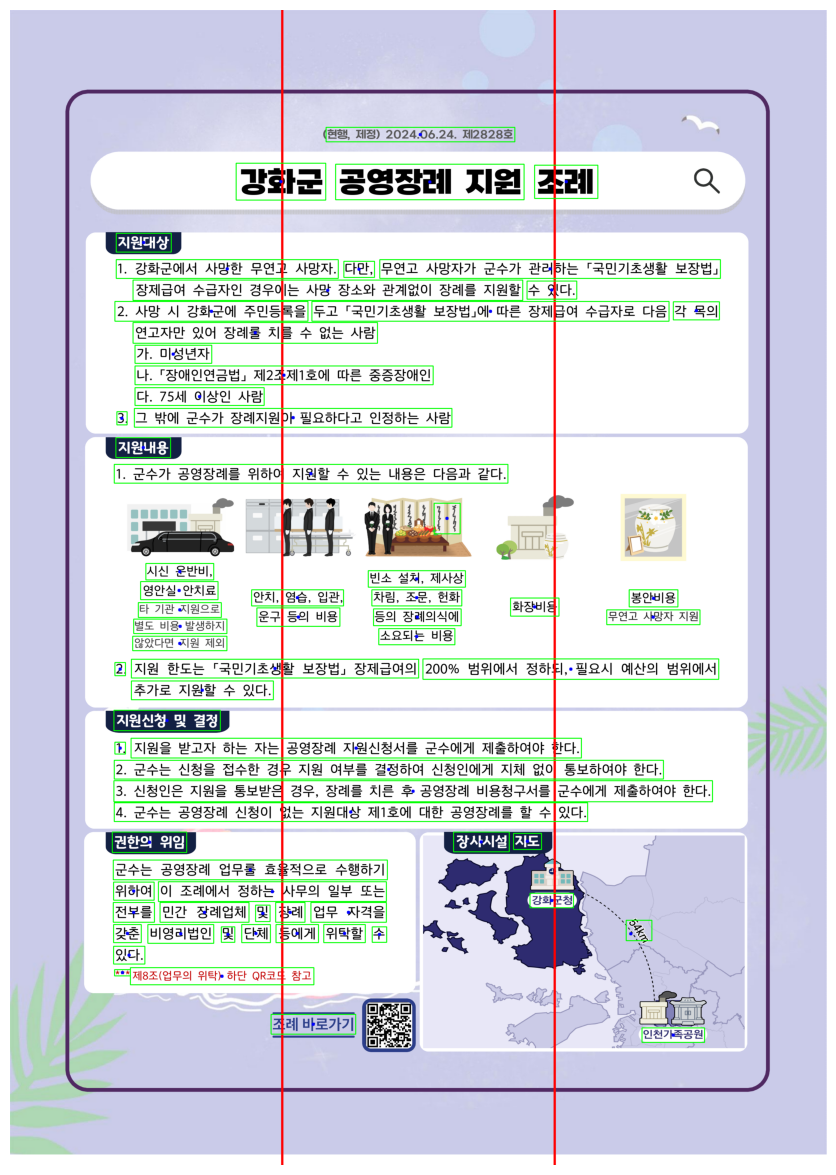

In [29]:
import matplotlib.pyplot as plt
import cv2

# 시각화를 위해 이미지 복사
debug_img = image_np.copy()
height, width, _ = debug_img.shape
threshold_1 = width / 3
threshold_2 = threshold_1 * 2
# 1. 내가 설정한 기준선(threshold) 그리기 (빨간선)
# 위에서 설정한 threshold_1, threshold_2 변수 사용
cv2.line(debug_img, (int(threshold_1), 0), (int(threshold_1), height), (255, 0, 0), 5) 
cv2.line(debug_img, (int(threshold_2), 0), (int(threshold_2), height), (255, 0, 0), 5)
# cv2.line(debug_img, (int(400), 0), (int(400), height), (255, 0, 0), 5)

# 2. OCR이 인식한 텍스트 박스 그리기 (초록박스)
for (bbox, text, prob) in result:
    (tl, tr, br, bl) = bbox
    
    # 박스 그리기
    pt1 = (int(tl[0]), int(tl[1]))
    pt2 = (int(br[0]), int(br[1]))
    cv2.rectangle(debug_img, pt1, pt2, (0, 255, 0), 2)
    
    # 텍스트 중심점 찍기 (파란점)
    center_x = int((tl[0] + tr[0]) / 2)
    center_y = int((tl[1] + bl[1]) / 2)
    cv2.circle(debug_img, (center_x, center_y), 5, (0, 0, 255), -1)

# 이미지 출력
plt.figure(figsize=(15, 15))
plt.imshow(debug_img)
plt.axis('off')
plt.show()

In [7]:
result

[([[np.int32(652), np.int32(212)],
   [np.int32(1016), np.int32(212)],
   [np.int32(1016), np.int32(244)],
   [np.int32(652), np.int32(244)]],
  '현행  제정) 2024.01.03. 제1671호',
  np.float64(0.4968716864801708)),
 ([[np.int32(608), np.int32(273)],
   [np.int32(863), np.int32(273)],
   [np.int32(863), np.int32(342)],
   [np.int32(608), np.int32(342)]],
  '서울특별시',
  np.float64(0.9824764632588374)),
 ([[np.int32(879), np.int32(276)],
   [np.int32(1035), np.int32(276)],
   [np.int32(1035), np.int32(338)],
   [np.int32(879), np.int32(338)]],
  '성동구',
  np.float64(0.999591875853089)),
 ([[np.int32(385), np.int32(347)],
   [np.int32(539), np.int32(347)],
   [np.int32(539), np.int32(411)],
   [np.int32(385), np.int32(411)]],
  '무연고',
  np.float64(0.8573444485664368)),
 ([[np.int32(557), np.int32(349)],
   [np.int32(713), np.int32(349)],
   [np.int32(713), np.int32(411)],
   [np.int32(557), np.int32(411)]],
  '사망자',
  np.float64(0.9931611411492176)),
 ([[np.int32(729), np.int32(349)],
   [np.int32

### clova OCR (구상 중 취소 : 사유, moeny)

In [23]:
from pdf2image import convert_from_path
import requests
import uuid
import json
import time
from PIL import Image
import io
import os
import numpy as np
from dotenv import load_dotenv
load_dotenv()


True

In [7]:
CLOVA_API_URL = os.getenv("CLOVA_API_URL");
CLOVA_SECRET_KEY = os.getenv("CLOVA_SECRET_KEY"); 

In [8]:
complex_pages = [19, 33, 35, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
print(complex_pages)

[19, 33, 35, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]


In [ ]:
def images_to_text_with_ocr(images, api_url, secret_key, complex_pages):
    """
    PDF → 이미지 변환 → OCR → 텍스트
    
    Args:
        pdf_path: PDF 파일 경로
        api_url: 클로바 OCR API Gateway URL
        secret_key: 클로바 OCR Secret Key
    
    Returns:
        str: 추출된 전체 텍스트 (페이지별로 \n\n 구분)
    """
    # complex_pages
    
    # 전체 페이지의 텍스트를 저장할 리스트    
    all_text = []
    all_result = []
    
    # 2. 각 페이지마다 OCR
    for i, img in enumerate(images):
        if (i+1) not in complex_pages:  # 복잡 페이지 아니면 그냥 가져가고 맞으면 중간 끼워 넣는 작업 해야할 듯. 
            continue

        if i != 18:
            continue

        print(f"Processing page {i+1}...")
        
        # PIL Image 객체를 BytesIO (메모리 상의 바이너리)로 변환
        img_byte_arr = io.BytesIO()
        img.save(img_byte_arr, format='PNG')    # PNG 형식으로 저장
        img_byte_arr.seek(0)    # 파일 포인터를 처음으로 되돌림
        
        # OCR API 요청 데이터 구성
        request_json = {
            'images': [{'format': 'png', 'name': f'page_{i+1}'}],   # 이미지 정보
            'requestId': str(uuid.uuid4()), # 고유 요청 ID (랜덤 생성)
            'version': 'V2',    # API 버전
            'timestamp': int(time.time() * 1000)    # 현재 시간 (밀리초)
        }
        
        # 요청 본문 (message)과 파일 데이터 준비
        payload = {'message': json.dumps(request_json).encode('UTF-8')}
        files = [('file', img_byte_arr)]    # 이미지 바이너리
        headers = {'X-OCR-SECRET': secret_key}  # 인증 헤더
        
        # OCR API 호출 (POST 요청)
        response = requests.post(api_url, headers=headers, data=payload, files=files)

        # 응답 성공 
        if response.status_code == 200:
            result = response.json()    # JSON 응답 파싱
            all_result.append(result)
            # 모든 필드의 inferText를 공백으로 연결
            # page_text = ' '.join([field['inferText'] 
            #                       for field in result['images'][0]['fields']])
            # all_text.append(page_text)  # 해당 페이지 텍스트 저장
        else:
            # 실패 시 에러 출력
            print(f"Page {i+1} failed: {response.status_code}")
            
    # 모든 페이지 텍스트를 \n\n로 구분하여 반환
    return all_result

In [ ]:
ordinance_book_path_1 = '../data/raw/ordinance_book/공영장례_조례집(서울_인천_경기).pdf'

images1 = convert_from_path(ordinance_book_path_1, dpi=300)


In [ ]:
if images1:
    image_np1 = np.array(images1[0])


In [ ]:
api_url = CLOVA_API_URL
secret_key = CLOVA_SECRET_KEY
complex_pages = [19, 33, 35, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]



results = images_to_text_with_ocr(images1, api_url, secret_key, complex_pages)    

Processing page 19...


In [29]:
dict2 = [{"name" : 'hello', 'byt' : 'byebye'}]
for dic in dict2:
    name, byt = dic.values()
    print(name, byt)


hello byebye


In [ ]:
result

[([[np.int32(963), np.int32(318)],
   [np.int32(1523), np.int32(318)],
   [np.int32(1523), np.int32(367)],
   [np.int32(963), np.int32(367)]],
  '(현행  제정) 2024.01.03. 제1671호',
  np.float64(0.5596805693267364)),
 ([[np.int32(910), np.int32(411)],
   [np.int32(1551), np.int32(411)],
   [np.int32(1551), np.int32(509)],
   [np.int32(910), np.int32(509)]],
  '서울특별시 성동구',
  np.float64(0.9752326989345133)),
 ([[np.int32(576), np.int32(522)],
   [np.int32(807), np.int32(522)],
   [np.int32(807), np.int32(615)],
   [np.int32(576), np.int32(615)]],
  '무연고',
  np.float64(0.8854432106018066)),
 ([[np.int32(834), np.int32(522)],
   [np.int32(1070), np.int32(522)],
   [np.int32(1070), np.int32(615)],
   [np.int32(834), np.int32(615)]],
  '사망자',
  np.float64(0.9996965544713919)),
 ([[np.int32(1095), np.int32(522)],
   [np.int32(1895), np.int32(522)],
   [np.int32(1895), np.int32(615)],
   [np.int32(1095), np.int32(615)]],
  '등 공영장례 지원 조례',
  np.float64(0.7609539398360067)),
 ([[np.int32(321), np.int3

In [15]:
results[0]['images'][0]['fields']

[{'valueType': 'ALL',
  'boundingPoly': {'vertices': [{'x': 959.0, 'y': 316.0},
    {'x': 1065.0, 'y': 316.0},
    {'x': 1065.0, 'y': 367.0},
    {'x': 959.0, 'y': 367.0}]},
  'inferText': '(현행,',
  'inferConfidence': 0.9989,
  'type': 'NORMAL',
  'lineBreak': False},
 {'valueType': 'ALL',
  'boundingPoly': {'vertices': [{'x': 1059.0, 'y': 316.0},
    {'x': 1153.0, 'y': 316.0},
    {'x': 1153.0, 'y': 363.0},
    {'x': 1059.0, 'y': 363.0}]},
  'inferText': '제정)',
  'inferConfidence': 0.9998,
  'type': 'NORMAL',
  'lineBreak': False},
 {'valueType': 'ALL',
  'boundingPoly': {'vertices': [{'x': 1150.0, 'y': 316.0},
    {'x': 1379.0, 'y': 316.0},
    {'x': 1379.0, 'y': 363.0},
    {'x': 1150.0, 'y': 363.0}]},
  'inferText': '2024.01.03.',
  'inferConfidence': 0.9954,
  'type': 'NORMAL',
  'lineBreak': False},
 {'valueType': 'ALL',
  'boundingPoly': {'vertices': [{'x': 1375.0, 'y': 316.0},
    {'x': 1526.0, 'y': 316.0},
    {'x': 1526.0, 'y': 363.0},
    {'x': 1375.0, 'y': 363.0}]},
  'infe

In [7]:
(329 + 486)/2,    268 * 1.5, 274 * 1.5

(407.5, 402.0, 411.0)

In [ ]:
ocr_data_list = []
start_trigger = False
# {'vertices': [{'x': 1375.0, 'y': 316.0},
#     {'x': 1526.0, 'y': 316.0},
#     {'x': 1526.0, 'y': 363.0},
#     {'x': 1375.0, 'y': 363.0}]}


# valueType, boundingPoly, inferText, inferConfidence, type, lineBreak
for dict in results[0]['images'][0]['fields']:
    (_, boundingPoly, inferText, inferConfidence, _,_) = dict.values()
    (tl, tr, br, bl) = boundingPoly['vertices']

    center_x = (tl['x'] + tr['x']) / 2 # 다음 이프문을 위해 중복 계산
    if text == "지원내용" and 402 <= center_x <= 411:
        start_trigger = True

    if not start_trigger:
        continue
    
    if text in ["권한의 위임", "장사시설", "지원신청 및 결정"] :
        break
    
    x1, x2 = int(tl['x']), int(tr['x'])
    y1, y2 = int(tl['y']), int(bl['y'])
    center_x = int((x1 + x2) / 2)
    center_y = int((y1 + y2) / 2)
    
    ocr_data_list.append({
        "text": text,
        "x1": x1, "x2": x2,
        "y1": y1, "y2": y2,
        "cx": center_x, 
        "cy": center_y,
        "used": False  # 사용자님 요청대로 사용 여부 체크
    })


ocr_data_list

In [ ]:
lines_list = []

pre_data = None
line_num = 1
region_num = 1
ocr_data_list = ocr_data_list[1:].copy()


MIN_COLUMN_GAP = 35 * DPI_MUL     # 띄어쓰기보다 훨씬 크면 컬럼 구분으로 생각하려고, 보통은 200DPI에서 10 ~ 15정도가 띄어쓰기임
LINE_GAP = 20 * DPI_MUL           # 줄 간격, 한 줄 내에서 많이 차이나면 10정도라서 그 두 배
CENTER_X_GAP = 5 * DPI_MUL        # text식별 박스의 x중앙값이 같은 컬럼이면 가운데 정렬이라 별 차이 안 나길래 일단 5 설정.
SOME_INT = 400 * DPI_MUL          # 이 값보다 크면 2번째 이상의 컬럼 text라고 판단할 임의의 값 지정

for idx, ocr_data in enumerate(ocr_data_list):
    # 이전 데이터 없으면 리스트에 딕셔너리 추가.
    if pre_data is None:
        lines_list.append({f'line{line_num}' : [ocr_data]})
        ocr_data['used'] = True
        pre_data = ocr_data
        continue

    # 리스트에 텍스트가 이미 들어갔다면 진행 안 함.
    if ocr_data['used'] == True:
        pre_data = ocr_data
        continue

    # 줄 바뀌지 않고, 이전 단어와 간격 작을 때는 이전 단어의 라인에 추가 (위치적으로 높으면 숫자 낮음)
    if (abs(pre_data['y1'] - ocr_data['y1']) <= LINE_GAP) and (ocr_data['x1'] - pre_data['x2'] < MIN_COLUMN_GAP):
        last_dict = lines_list[-1]
        current_key = list(last_dict.keys())[0]
        last_dict[current_key].append(ocr_data)
        pre_data = ocr_data
        continue

    # 1번째 구역 글이 처음 발견
    if (idx + 1 < len(ocr_data_list)) and (abs(pre_data['y1'] - ocr_data['y1']) > LINE_GAP) and (ocr_data_list[idx+1]['x1'] - ocr_data['x2'] >= MIN_COLUMN_GAP):
        lines_list.append({f'region{region_num}' : [ocr_data]})
        ocr_data['used'] = True

        for data in ocr_data_list: 
            if not data['used'] and abs(data['cx'] - ocr_data['cx']) <= CENTER_X_GAP:
                lines_list[-1][f'region{region_num}'].append(data)
                data['used'] = True

        region_num += 1
        pre_data = ocr_data
        continue

    # 2번째, 3번째, (있다면 4번째) 구역 글
    if (ocr_data['x1'] - pre_data['x2'] >= MIN_COLUMN_GAP) or (abs(pre_data['y1'] - ocr_data['y1']) > LINE_GAP and ocr_data['x1'] > SOME_INT) :
        lines_list.append({f'region{region_num}' : [ocr_data]})
        ocr_data['used'] = True

        for data in ocr_data_list: 
            if not data['used'] and abs(data['cx'] - ocr_data['cx']) <= CENTER_X_GAP:
                lines_list[-1][f'region{region_num}'].append(data)
                data['used'] = True

        region_num += 1
        pre_data = ocr_data
        continue

    # 줄 바뀌면 다음 라인으로 생성
    if abs(pre_data['y1'] - ocr_data['y1']) > LINE_GAP:
        lines_list.append({f'line{line_num}' : [ocr_data]})
        line_num += 1
        ocr_data['used'] = True
        pre_data = ocr_data
        continue    


In [ ]:
final_lines_list = [
    " ".join([item['text'] for item in list(line_dict.values())[0]]) 
    for line_dict in lines_list
]

# 결과 확인
for line in final_lines_list:
    print(line)

### 클로바OCR 시각화

In [15]:
import matplotlib.pyplot as plt
import cv2

# 시각화를 위해 이미지 복사
debug_img = image_np1.copy()
height, width, _ = debug_img.shape
threshold_1 = width / 3
threshold_2 = threshold_1 * 2
# 1. 내가 설정한 기준선(threshold) 그리기 (빨간선)
# 위에서 설정한 threshold_1, threshold_2 변수 사용
cv2.line(debug_img, (int(threshold_1), 0), (int(threshold_1), height), (255, 0, 0), 5) 
cv2.line(debug_img, (int(threshold_2), 0), (int(threshold_2), height), (255, 0, 0), 5)
# cv2.line(debug_img, (int(400), 0), (int(400), height), (255, 0, 0), 5)

# 2. OCR이 인식한 텍스트 박스 그리기 (초록박스)
for dict in results[0]['images'][0]['fields']:
    (_, boundingPoly, inferText, inferConfidence, _,_) = dict.values()
    (tl, tr, br, bl) = boundingPoly['vertices']
    
    # 박스 그리기
    pt1 = (int(tl['x']), int(tl['y']))
    pt2 = (int(br['x']), int(br['y']))
    cv2.rectangle(debug_img, pt1, pt2, (0, 255, 0), 2)
    
    # 텍스트 중심점 찍기 (파란점)
    center_x = int((tl['x'] + tr['x']) / 2)
    center_y = int((tl['y'] + bl['y']) / 2)
    cv2.circle(debug_img, (center_x, center_y), 5, (0, 0, 255), -1)

# 이미지 출력
plt.figure(figsize=(15, 15))
plt.imshow(debug_img)
plt.axis('off')
plt.show()

NameError: name 'image_np1' is not defined

### pdfplumber bbox(찐 최종)

In [81]:
import pdfplumber
import pikepdf
import os


BASE_DIR = '../data/raw/ordinance_book/'

TARGET_FILES = [
    '공영장례_조례집(광주_전북_전남).pdf',
    '공영장례_조례집(대구_경북_강원).pdf',
    '공영장례_조례집(대전_세종_충북_충남).pdf',
    '공영장례_조례집(부산_울산_경남_제주).pdf',
    '공영장례_조례집(서울_인천_경기).pdf'
]

def process_pdf(filenames):
    extracted_pages = [] 
    for filename in filenames:
        original_file_path = os.path.join(BASE_DIR, filename)
        repaired_file_path = os.path.join(BASE_DIR, filename.replace('.pdf', '_repaired.pdf'))
        
        print(f"\n[{filename}] 파일 처리 시작...")
        try:  # pikepdf : 복구해주는 라이브러리, 단 지금은 작은 정도의 오류를 해결할 용도로 사용. 
            with pikepdf.open(original_file_path) as pdf:
                pdf.save(repaired_file_path)
            target_file = repaired_file_path
        except Exception as e:
            print(f"복구 실패, 원본 사용: {e}")
            target_file = original_file_path

        current_file_failed_pages = []  # extract_words 추출 실패 시 몇 페이지인지 알려주기 위해.

        with pdfplumber.open(target_file) as pdf:
            target_pages = pdf.pages[14:-2]  # 앞14페이지, 뒤2페이지는 버림
            
            raw_word_list = []
            for i, page in enumerate(target_pages):
                current_page_num = 15 + i
                
                try:        # x_tolerance는 10, y는 3으로 words 추출, x간격 10픽셀 이하면 묶어 줌
                    raw_words = page.extract_words(x_tolerance=10, y_tolerance=3, keep_blank_chars=True)
                except Exception as e:
                    current_file_failed_pages.append(current_page_num)
                    print("extract중 오류 발생", e)
                    continue
                if raw_words:
                    raw_word_list.append(raw_words)

            extracted_pages += raw_word_list    
            
    return extracted_pages


extracted_pages = process_pdf(TARGET_FILES)
extracted_pages


[공영장례_조례집(광주_전북_전남).pdf] 파일 처리 시작...

[공영장례_조례집(대구_경북_강원).pdf] 파일 처리 시작...

[공영장례_조례집(대전_세종_충북_충남).pdf] 파일 처리 시작...

[공영장례_조례집(부산_울산_경남_제주).pdf] 파일 처리 시작...

[공영장례_조례집(서울_인천_경기).pdf] 파일 처리 시작...
extract중 오류 발생 'DescendantFonts'
extract중 오류 발생 'DescendantFonts'


[[{'text': '(현행, 일부개정) 2024.05.31. 제6380호',
   'x0': 227.88,
   'x1': 383.8776,
   'top': 89.32799999999997,
   'doctop': 12101.328,
   'bottom': 97.36799999999994,
   'upright': True,
   'height': 8.039999999999964,
   'width': 155.99759999999998,
   'direction': 'ltr'},
  {'text': '광주광역시 복지장례 지원 조례',
   'x0': 154.44,
   'x1': 435.12280799999996,
   'top': 118.72799999999995,
   'doctop': 12130.728,
   'bottom': 138.76800000000003,
   'upright': True,
   'height': 20.040000000000077,
   'width': 280.68280799999997,
   'direction': 'ltr'},
  {'text': '지원대상',
   'x0': 81.48,
   'x1': 119.985312,
   'top': 169.36800000000005,
   'doctop': 12181.368,
   'bottom': 180.40800000000002,
   'upright': True,
   'height': 11.039999999999964,
   'width': 38.50531199999999,
   'direction': 'ltr'},
  {'text': '사망일 기준 시에 주민등록을 두고 실거주한 사람 중, 장례절차를 시 관내에서 수행하면서 다음 어느 ',
   'x0': 80.28,
   'x1': 534.149136,
   'top': 189.312,
   'doctop': 12201.312,
   'bottom': 199.27199999999993,
   'upright': True,


In [92]:
all_data_list = []
for page in extracted_pages:
    # 페이지별 실행.
    if not page:
        continue

    usable_data_list = []

    for word_dict in page:
        # 단어별 실행
        (text, x1, x2, y1, _, y2, _, _, width, _) = word_dict.values() 
        # print(text)
        center_x = (x1 + x2) / 2 
        center_y = (y1 + y2) / 2
        
        if not text.strip():
            # 공백문자를 text로 가져온 경우 넘어가기
            continue
        
        if text in ["권한의 위임", "장사시설 지도", "지원신청 및 결정"] :
            break


        usable_data_list.append({
        "text": text.strip(),
        "x1": x1, "x2": x2,
        "y1": y1, "y2": y2,
        "cx": center_x, 
        "cy": center_y,
        "used": False  # 사용 여부 체크
        })
        continue

    if usable_data_list:
        all_data_list.append(usable_data_list)

# all_data_list : 페이지별로 딕셔너리 리스트가 묶인 리스트.

WIDTH = 612
HEIGHT = 858
MIN_COLUMN_GAP = 8      # 띄어쓰기보다 훨씬 크면 컬럼 구분으로 생각하려고
LINE_GAP = 10           # 줄 간격, 한 줄 내에서 많이 차이나지 않음
CENTER_X_GAP = 2        # text박스의 x중앙값이 같은 컬럼이면 가운데 정렬이라 별 차이 안 남
SOME_INT = 153          # 이 값보다 크면 2번째 이상의 컬럼 text라고 판단할 임의의 값 지정
ordinance_list = []
for one_page_data_list in all_data_list:
    lines_list = []
    pre_data = None
    line_num = 1
    region_num = 1

    for idx, cur_data in enumerate(one_page_data_list):
        # 이전 데이터 없으면 리스트에 딕셔너리 추가.
        if pre_data is None:
            lines_list.append({f'line{line_num}' : [cur_data]})
            line_num += 1
            cur_data['used'] = True
            pre_data = cur_data
            continue

        # 리스트에 텍스트가 이미 들어갔다면 진행 안 함.
        if cur_data['used'] == True:
            pre_data = cur_data
            continue

        # 1번째 구역 글 발견
        if (idx + 1 < len(one_page_data_list)) and (one_page_data_list[idx+1]['x1'] - cur_data['x2'] >= MIN_COLUMN_GAP):
            lines_list.append({f'region{region_num}' : [cur_data]})
            cur_data['used'] = True

            for data in one_page_data_list: 
                if not data['used'] and abs(data['cx'] - cur_data['cx']) <= CENTER_X_GAP:
                    lines_list[-1][f'region{region_num}'].append(data)
                    data['used'] = True

            region_num += 1
            pre_data = cur_data
            continue

        # 2번째 이상 컬럼. 한 줄이면 묶여있으니 그냥 떨어진 시작이면 컬럼으로 간주.
        if (cur_data['x1'] >= SOME_INT) and (cur_data['y1'] >= 858 / 5):
            # 제목은 제외.
            
            lines_list.append({f'region{region_num}' : [cur_data]})
            cur_data['used'] = True

            for data in one_page_data_list: 
                if not data['used'] and abs(data['cx'] - cur_data['cx']) <= CENTER_X_GAP:
                    lines_list[-1][f'region{region_num}'].append(data)
                    data['used'] = True

            region_num += 1
            pre_data = cur_data
            continue    
        # 줄 바뀌면 다음 라인으로 생성
        if abs(pre_data['y1'] - cur_data['y1']) > LINE_GAP:
            lines_list.append({f'line{line_num}' : [cur_data]})
            line_num += 1
            cur_data['used'] = True
            pre_data = cur_data
            continue    

    final_line = "\n".join(" ".join([item['text'] for item in list(line_dict.values())[0]]) for line_dict in lines_list)
    ordinance_list.append(final_line)

ordinance_list2 = ordinance_list + ['''(현행, 일부개정) 2025.10.02. 제2558호
평택시 무연고 사망자 등에 대한
장례 지원 조례 
지원대상
이 조례의 지원대상은 평택시 관내에서 사망한 사람이 다음 어느 하나에 해당하는 경우로 한다. 1. 「장사 등에 관한 법률」 제2조제16호에 따른 연고자가 없거나 「국민기초생활보장법」 제2조제5호에
 따른 부양의무자가 없거나 사망자의 신원이 확보되지 않아 연고자를 알 수 없는 경우
2. 사망자의 연고자가 있으나 연고자가 사회적·경제적·신체적 능력 부족 및 가족관계 단절 등 불가피한
 이유로 시신 인수를 거부·기피하는 경우
지원내용
1. 무연고 사망자 장례지원은 현금으로 지원함을 원칙으로 한다. 다만, 현금지원이 적당하지 아니하다고
 인정되는 경우에는 물품으로 지원할 수 있다. 2. 물품 지원범위는 다음과 같다.
수의, 관, 상복, 염사
그 밖에 장례에 필요한
용품
사체 검안비, 운반비, 영안실 안치료
장례업체, 민간기관, 비영리단체 등과의 연계
통한 인력 및 장소
화장비용''']
ordinance_list3 = ordinance_list2 + ['''(현행, 제정) 2021.11.23. 제1998호
하남시 공영장례 지원에 관한 조례
지원대상
시장은 사망 당시 시에 주민등록이 되어 있거나 관내에서 사망한 자가 다음 어느 하나에 해당하는
경우 공영장례 지원을 할 수 있다. 1. 연고자가 없거나 알 수 없는 경우
2. 연고자가 있으나 가족관계 단절 등 불가피한 사유로 시신 인수를 거부·기피하는 경우
3. 그 밖에 공영장례 지원이 필요하다고 시장이 인정하는 경우
다른 법령에 따라 장례비용을 지원받은 때에는 공영장례 지원 대상에서 제외한다. 다만, 다른 법령에
따라 지원받은 금액이 이 조례에서 지원하는 금액보다 적은 경우 그 부족액을 지원할 수 있다. 
지원내용
1. 시장이 공영장례 지원을 할 수 있는 내용은 다음과 같다.
수의, 관, 유골함 등 장례용품 또는
그에 상응하는 비용
장의차량, 장례식장, 화장시설
사용료
2. 시장은 화장문화 장려를 위해 매장 비용은 지원하지 않는다.''']
ordinance_list4 = [] 
for text in ordinance_list3:
    ordinance_list4.append(text.replace("***제5조(지원내용) 하단 QR코드 참고", ""))
ordinance_list5 = [] 
for text in ordinance_list4:
    ordinance_list5.append(text.replace("***제6조(지원내용) 하단 QR코드 참고", ""))
ordinance_list6 = [] 
for text in ordinance_list5:
    ordinance_list6.append(text.replace("***제5조(지원내용)의 상세 내용은 하단 QR코드 참고", ""))
ordinance_list7 = [] 
for text in ordinance_list6:
    ordinance_list7.append(text.replace("***제4조(지원내용) 하단 QR코드 참고", ""))
ordinance_list8 = [] 
for text in ordinance_list7:
    ordinance_list8.append(text.replace("***제5조(지원방법 및 지원내용) 하단 QR코드 참고", ""))

ordinance_list8

['(현행, 일부개정) 2024.05.31. 제6380호\n광주광역시 복지장례 지원 조례\n지원대상\n사망일 기준 시에 주민등록을 두고 실거주한 사람 중, 장례절차를 시 관내에서 수행하면서 다음 어느\n하나에 해당하는 경우 복지장례를 지원할 수 있다. 지원대상자 선정기준 및 절차 등은 시장이 정한다.\n1. 무연고자\n2. 저소득층으로서 다음의 연고자만 있어 장례를 치를 수 없는 사람\n가. 미성년자, 나. 「장애인연금법」 제2조제1호에 따른 중증장애인, 다. 75세 이상인 사람\n3. 「광주광역시 고독사 예방 및 사회적 고립가구 지원 조례」 제2조제1항에 따른 고독사로 자치구청장·\n동장·마을공동체 등에서 장례를 치르는 사망자\n4. 「광주광역시 아동학대 예방 및 피해아동 보호 조례」 제2조제3호에 따른 아동학대로 인해 사망한\n경우로 연고자가 구속·가족관계 단절 등의 사유로 장례를 치를 수 없는 사망자\n5. 그 밖에 복지장례 지원이 필요하다고 시장 또는 구청장이 인정한 경우\n지원내용\n1. 시장은 장례절차의 전부 또는 일부에 대하여 다음의 내용을 지원할 수 있다.\n가. 「장사 등에 관한 법률」 제29조의2에 따른 장례지도사 및 장례지원 인력의 지원\n나. 시신 운반비, 영안실 안치료(다만, 경찰·소방 등 다른 기관의 지원이 있어 별도 비용이 발생하지\n않은 경우 제외)\n다. 빈소 설치, 입관, 조문, 헌화, 운구 등 장례의식에 소요되는 장례물품, 장례장소 및 장례차량 등\n비용\n라. 화장비용\n마. 봉안(무연고자 해당)\n***제7조(지원내용) 하단 QR코드 참고',
 '(현행, 일부개정) 2024.05.14. 제1736호\n광주광역시 동구 공영장례 지원에 관한 조례\n지원대상\n구청장은 사망 시 구에 주민등록을 두고 실제로 거주하던 사망자가 다음 어느 하나에 해당하는 경우에\n공영장례지원을 할 수 있다.\n1. 연고자가 없거나 연고자가 있으나 시신 인수를 거부·기피하는 경우\n2. 연고자가 미성년자 또는 장애인으로만 구성되어 있어 장례처리 능력이

### 최종본 시각화

In [ ]:
import matplotlib.pyplot as plt
import cv2
from pdf2image import convert_from_path

pages = convert_from_path('../data/raw/ordinance_book/공영장례_조례집(광주_전북_전남).pdf', dpi = 300)

NameError: name 'np' is not defined

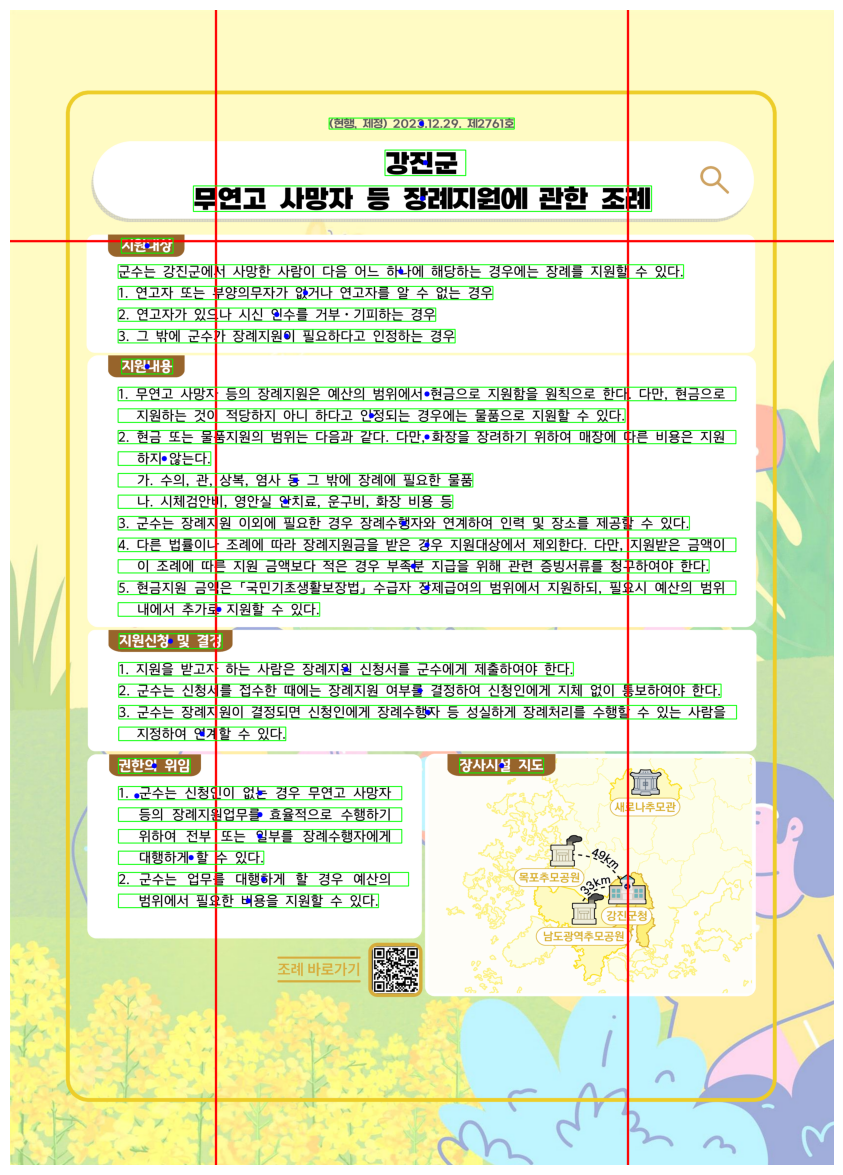

In [63]:
import numpy as np
SCALE = 2550 / 612  # (3575, 2550) / (858, 612)
if pages:
    image_np = np.array(pages[52])

height, width, _ = image_np.shape
threshold_1 = width / 4
threshold_2 = threshold_1 * 3

# 1. 내가 설정한 기준선(threshold) 그리기 (빨간선)
# 위에서 설정한 threshold_1, threshold_2 변수 사용
cv2.line(image_np, (int(threshold_1), 0), (int(threshold_1), height), (255, 0, 0), 5) 
cv2.line(image_np, (int(threshold_2), 0), (int(threshold_2), height), (255, 0, 0), 5)
# cv2.line(image_np, (int(400), 0), (int(400), height), (255, 0, 0), 5)
cv2.line(image_np, (0, int(height / 5)), (width, int(height / 5)), (255, 0, 0), 5)

for idx, page in enumerate(extracted_pages):
    if idx == 33:
        for word_dict in page:
            # 단어별 실행
            (text, x1, x2, y1, _, y2, _, _, _, _) = word_dict.values() 
            # print(text)
            x1_img = int(x1 * SCALE)
            x2_img = int(x2 * SCALE)
            y1_img = int(y1 * SCALE)
            y2_img = int(y2 * SCALE)
            center_x_img = int((x1_img + x2_img) / 2)
            center_y_img = int((y1_img + y2_img) / 2)
            
            cv2.rectangle(image_np, (x1_img, y1_img), (x2_img, y2_img), (0, 255, 0), 2)
            cv2.circle(image_np, (center_x_img, center_y_img), 8, (0, 0, 255), -1)

        # 이미지 출력
        plt.figure(figsize=(15, 15))
        plt.imshow(image_np)
        plt.axis('off')
        plt.show()